In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


df = pd.read_csv("SENSEX_01121997_13122025.csv")

df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

df = df[['Date', 'Open', 'High', 'Low', 'Close']]


train_df = df[df['Date'] < '2020-01-01']
test_df  = df[df['Date'] >= '2020-01-01']

X_train_raw = train_df[['Open', 'High', 'Low']].values
y_train_raw = train_df[['Close']].values

X_test_raw  = test_df[['Open', 'High', 'Low']].values
y_test_raw  = test_df[['Close']].values


X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_train_scaled = X_scaler.fit_transform(X_train_raw)
X_test_scaled  = X_scaler.transform(X_test_raw)

y_train_scaled = y_scaler.fit_transform(y_train_raw)
y_test_scaled  = y_scaler.transform(y_test_raw)

pca = PCA(n_components=2)   # reduce OHL → 2 components
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)

def create_sequences(X, y, lookback=60):
    X_seq, y_seq = [], []
    for i in range(lookback, len(X)):
        X_seq.append(X[i-lookback:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

LOOKBACK = 60

X_train, y_train = create_sequences(X_train_pca, y_train_scaled, LOOKBACK)
X_test, y_test   = create_sequences(X_test_pca, y_test_scaled, LOOKBACK)

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(LOOKBACK, X_train.shape[2])),
    Dropout(0.2),

    LSTM(32),
    Dropout(0.2),

    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

early_stop = EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=60,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

pred_scaled = model.predict(X_test)

predicted_close = y_scaler.inverse_transform(pred_scaled)
actual_close = y_scaler.inverse_transform(y_test)

rmse = np.sqrt(mean_squared_error(actual_close, predicted_close))
r2 = r2_score(actual_close, predicted_close)

print("LSTM PERFORMANCE")
print("Root Mean Squared Error:", rmse)
print("R²:", r2)


C:\Users\Rahul Gaonkar\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        17,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,601 (115.63 KB)

 Trainable params: 29,601 (115.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
153/153 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step - loss: 0.0066 - val_loss: 5.9023e-04
Epoch 2/60
153/153 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 0.0014 - val_loss: 4.5364e-04
Epoch 3/60
153/153 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 0.0013 - val_loss: 0.0052
Epoch 4/60
153/153 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 5/60
153/153 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - loss: 0.0011 - val_loss: 0.0048
Epoch 6/60
153/153 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - loss: 0.0010 - val_loss: 5.7188e-04
Epoch 7/60
153/153 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - loss: 9.5944e-04 - val_loss: 0.0023
Epoch 8/60
153/153 ━━━━━━━━━━━━━━━━━━━━ 12s 78ms/step - loss: 8.4916e-04 - val_loss: 7.1568e-04
Epoch 9/60
153/153 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - loss: 8.9730e-04 - val_loss: 0.0018
Epoch 10/60
153/153 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - loss: 7.8352e-04 - val_loss: 3.0506e-04
Epoch 11/60
153/153 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - loss: 7.1310e-04 - val_loss: 8.2092

In [3]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(actual_close, predicted_close)
mape = np.mean(np.abs((actual_close - predicted_close) / actual_close)) * 100
actual_dir = np.sign(np.diff(actual_close.flatten()))
pred_dir = np.sign(np.diff(predicted_close.flatten()))
directional_accuracy = np.mean(actual_dir == pred_dir) * 100
naive_forecast = actual_close[:-1]
theil_u = np.sqrt(np.mean((predicted_close[1:] - actual_close[1:])**2)) / \
          np.sqrt(np.mean((naive_forecast - actual_close[1:])**2))

print("Mean Absolute Error :", mae)
print("Mean Absolute Percentage Error %:", mape)
print("Directional Accuracy %:", directional_accuracy)
print("Theil's U :", theil_u)


Mean Absolute Error : 3836.9618166813384
Mean Absolute Percentage Error %: 5.504566750244157
Directional Accuracy %: 53.911205073995774
Theil's U : 8.345778967418022


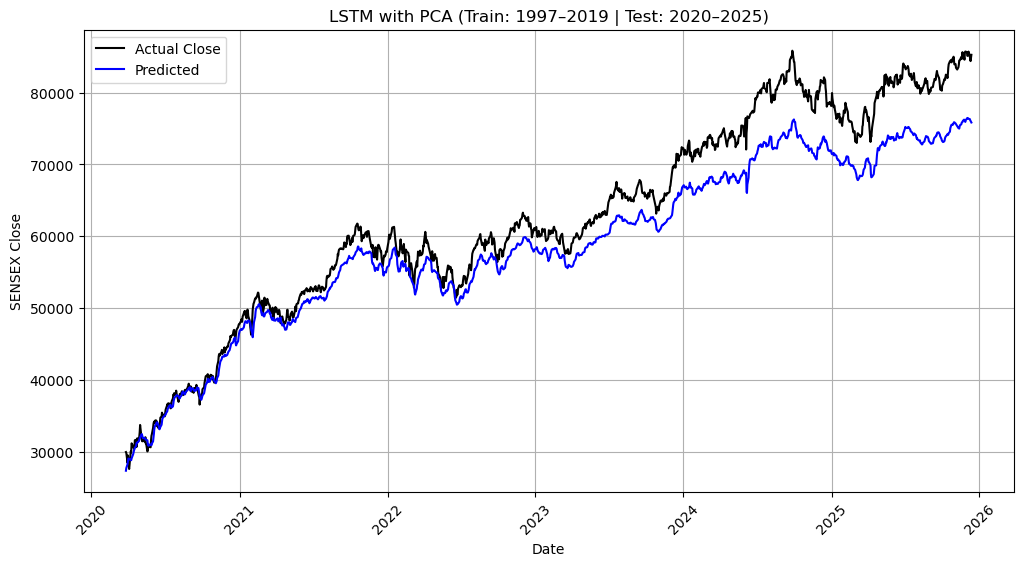

In [17]:
test_dates = test_df['Date'].iloc[LOOKBACK:].values
plt.figure(figsize=(12,6))
plt.plot(test_dates, actual_close, label="Actual Close", color='black')
plt.plot(test_dates, predicted_close, label="Predicted", color='blue')
plt.title("LSTM with PCA (Train: 1997–2019 | Test: 2020–2025)")
plt.xlabel("Date")
plt.ylabel("SENSEX Close")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


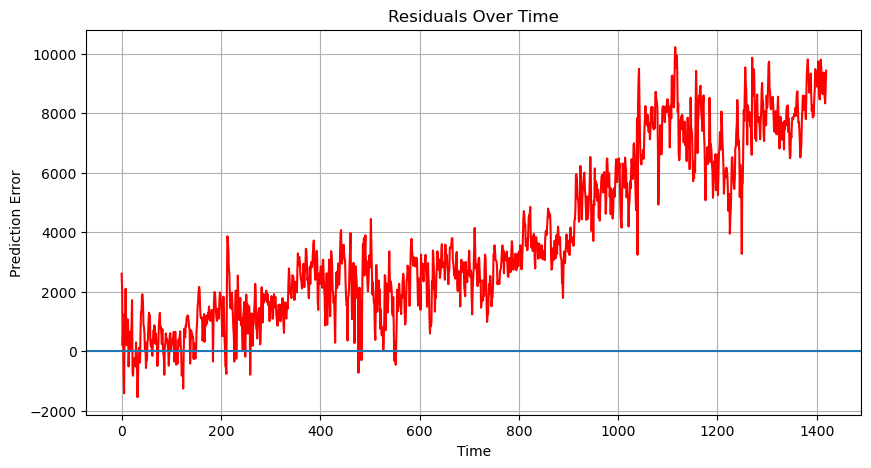

In [5]:
residuals = actual_close.flatten() - predicted_close.flatten()

plt.figure(figsize=(10,5))
plt.plot(residuals,color = 'red')
plt.axhline(0)
plt.title("Residuals Over Time")
plt.xlabel("Time")
plt.ylabel("Prediction Error")
plt.grid(True)
plt.show()


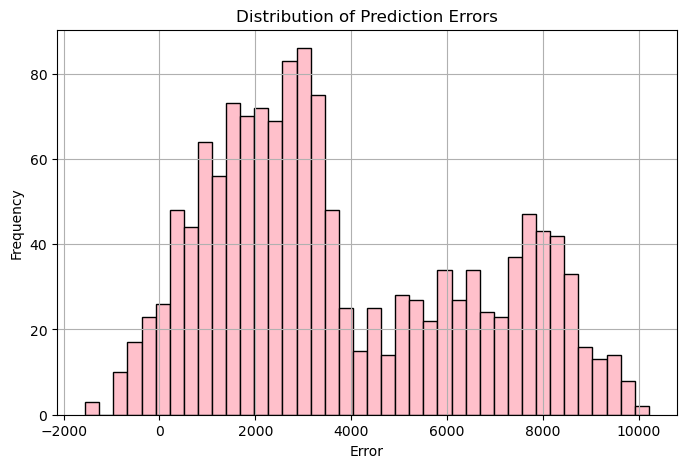

In [15]:
plt.figure(figsize=(8,5))
plt.hist(residuals, bins=40,edgecolor = 'black',color ='pink')
plt.title("Distribution of Prediction Errors")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


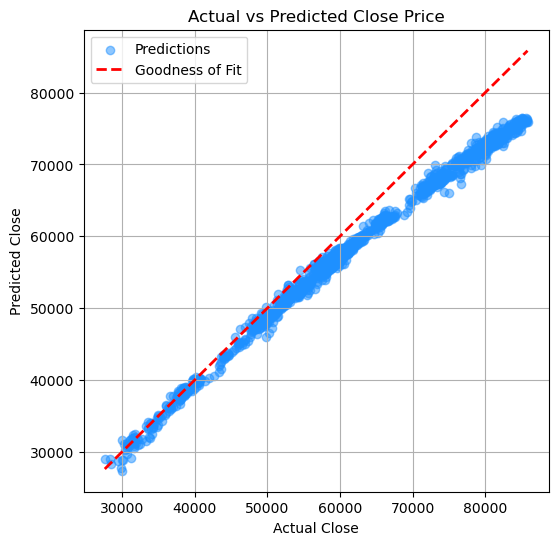

In [13]:
plt.figure(figsize=(6,6))
plt.scatter(
    actual_close,
    predicted_close,
    alpha=0.5,
    color='dodgerblue',
    label='Predictions'
)

plt.plot(
    [actual_close.min(), actual_close.max()],
    [actual_close.min(), actual_close.max()],
    color='red',
    linestyle='--',
    linewidth=2,
    label='Goodness of Fit'
)

plt.xlabel("Actual Close")
plt.ylabel("Predicted Close")
plt.title("Actual vs Predicted Close Price")
plt.legend()
plt.grid(True)
plt.show()
